In [1]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.keras import TqdmCallback

from collections import Counter

import pandas as pd
import numpy as np
import seaborn as sns
from pandas.core.indexing import _IndexSlice
import matplotlib.pyplot as plt
from functools import partial
import umap
from sklearn.preprocessing import StandardScaler
from pandas.core.dtypes.common import is_numeric_dtype, is_object_dtype
import datetime

import itertools

from pathlib import Path

import common_functions as fnc

idx: _IndexSlice = pd.IndexSlice

2025-06-05 19:52:20.615342: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-05 19:52:20.615850: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-05 19:52:20.619084: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-05 19:52:20.626989: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749145940.640685 3407340 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749145940.64

/home/tobias/University/ojip_mlmodel/data_import.py:85: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0.3, hspace=0.7)


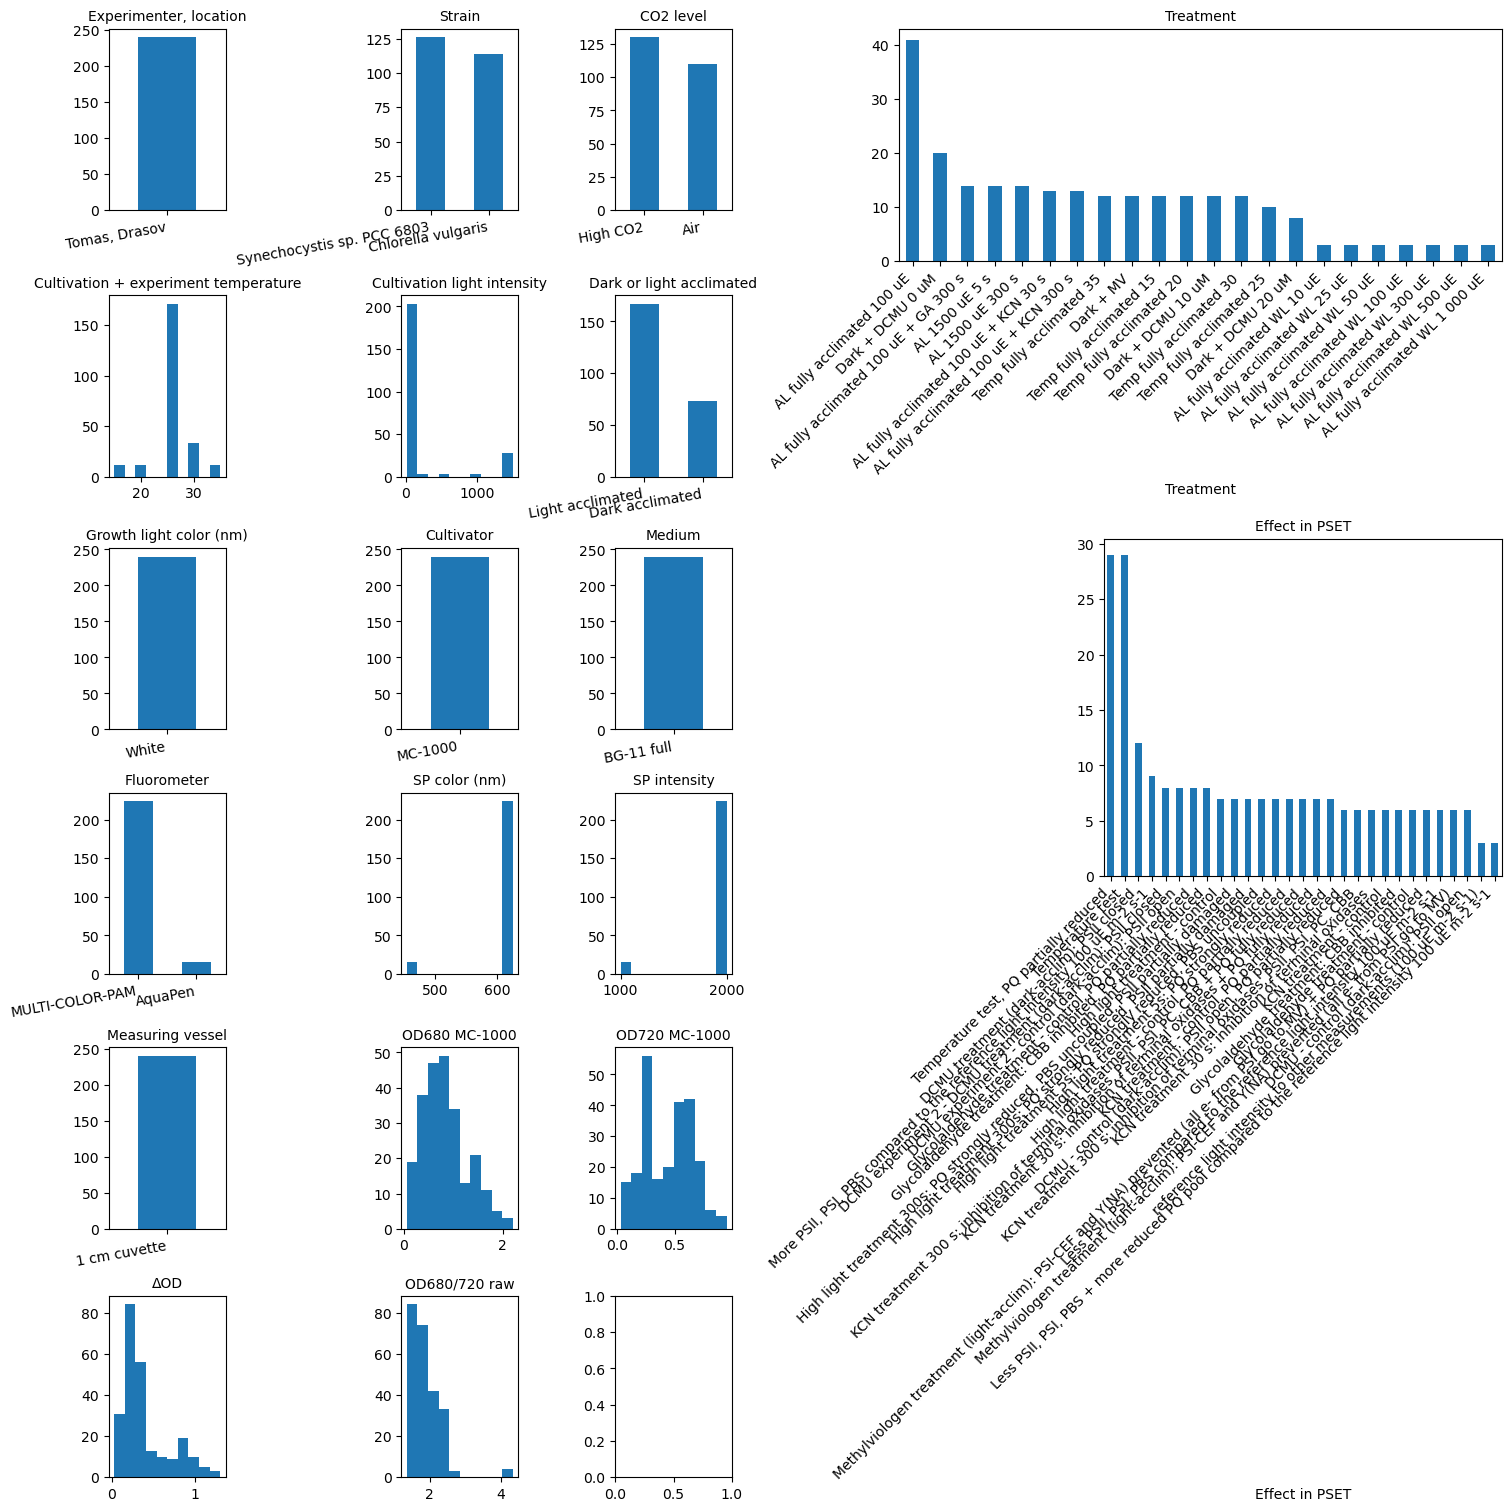

In [2]:
from data_import import df, samples, didx, DATA_PATH

## Example plots

Text(0.5, 1.0, 'AquaPen - Example')

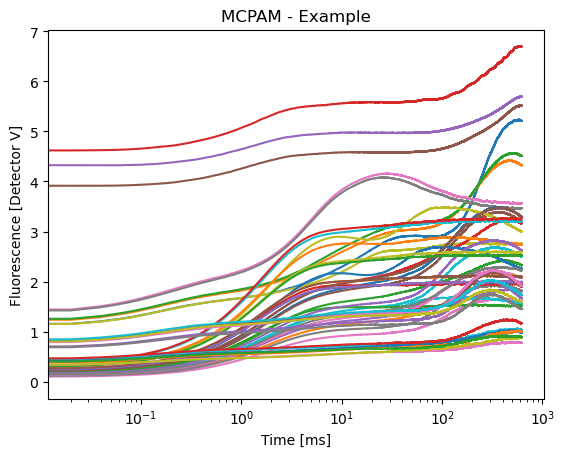

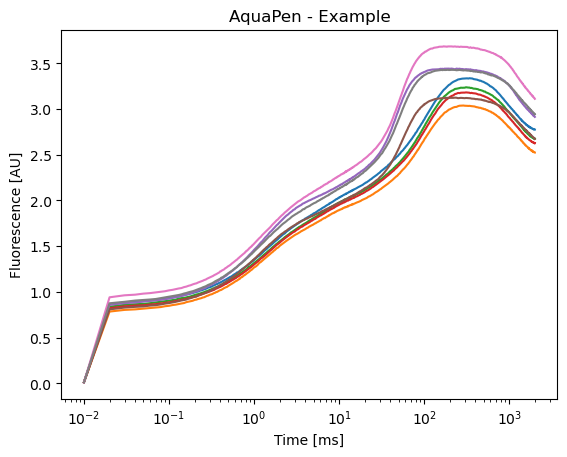

In [3]:
# Example plots
ax = df.loc[:, didx(
    fluorometer="MULTI-COLOR-PAM",
    CO2_level="Air", 
    strain="Chlorella vulgaris",
    # SP_color=455
)].dropna().plot(legend=False)
ax.set_xscale("log")
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Fluorescence [Detector V]")
ax.set_title("MCPAM - Example")

ax = df.loc[:, didx(fluorometer="AquaPen", CO2_level="Air")].dropna().plot(legend=False)
ax.set_xscale("log")
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Fluorescence [AU]")
ax.set_title("AquaPen - Example")

# Model training

In [4]:
SEED = 42

## Select the data to be trained on

In [5]:
dat = df.loc[
    0.01:, : # Exclude data before the light pulse
    # didx(
    #     fluorometer="MULTI-COLOR-PAM", # Only use MCPAM data
    #     strain='Synechocystis sp. PCC 6803', # Only use Synechocystis data
    # )
].dropna()

### Map the treatment effects

In [6]:
test  = pd.read_csv(
    DATA_PATH / "effects_map.csv",
    header=[0,1],
    index_col=[0,1],
    ).astype(float).fillna(0).astype(bool)

In [7]:
# Read the map of effects transformed into one-hot encoding
effects_map_raw = pd.read_csv(
    DATA_PATH / "effects_map.csv",
    header=[0,1],
    index_col=[0,1],
    ).astype(float).fillna(0).astype(bool)

# Exclude Light intensity and temperature from targets
effects_map = effects_map_raw[[
    'control_measurement',
    'PSII_closed',
    'CBB_inhibited',
    'TOX_inhibited',
    'electron_drain'
]]

# Set High light as a closing factor of PSII
effects_map.loc[:,'PSII_closed'] = np.logical_or(
    effects_map['PSII_closed'].to_numpy(),
    effects_map_raw["high_light"].to_numpy()
)

# Ass high and low temperature as 
effects_map.loc[:,'control_measurement'] = np.logical_or(
    effects_map['control_measurement'].to_numpy(),
    effects_map_raw["low_temperature"].to_numpy()
)
effects_map.loc[:,'control_measurement'] = np.logical_or(
    effects_map['control_measurement'].to_numpy(),
    effects_map_raw["high_temperature"].to_numpy()
)
effects_map.loc[:,'control_measurement'] = np.logical_or(
    effects_map['control_measurement'].to_numpy(),
    effects_map_raw["low_light"].to_numpy()
)

# Get the effects and map the mto the targets
effects = samples.loc[dat.columns.get_level_values(0), ["Effect in PSET", "Treatment"]]

targets = effects_map.loc[pd.MultiIndex.from_frame(effects)].droplevel(1, axis=1)
targets = targets.astype(int)
targets.index = dat.columns

# Make a Multiindex with a duplicated entries
target_names = targets.columns
targets.columns = pd.MultiIndex.from_arrays(arrays=[targets.columns, targets.columns])

# Select features

**Message from Tomas:**

INPUTS
- Strain: Synechocystis / Chlorella. Later, when we have more strains measured, we can make it more general like green algae/cyanobacteria.
- Temperature: **it could be enough to keep it in intervals, like e.g. 15-20 / 20-25 / 25-30 / 30-35 etc.**
- Light acclimation state: light-acclimated / dark-acclimated
- OD: needs to be standardized = measured by one device since each device measure OD differently.  In the dataset we now have it for Multi-Cultivator, but it would be better to refer to UV-Vis and 1 cm cuvette. Alternatively, chlorophyll content could work well. I can provide all these values, based on additional measurements that we have already performed.
- SP color: **blue / orange-red could be enough**
- SP Intensity: saturating / non-saturating. This parameter definitely matters, but it could be tricky for the users to validate if SP is saturating or not. So, alternatively, the user can provide SP intensity (**perhaps again in some intervals like < 1000 / 1000-1500 / 1500-2000 / 2000-2500 / >2500**) and we can evaluate by our algorithm if the SP was saturating, based on the selection of strain, OD, SP color and SP intensity.
- Fluorometer: MCPAM / AquaPen - I would keep it for now, since I am still not sure if there is any fundamental difference between MC-PAM, AquaPen and FL-6000, or not. But in general, it should be only SP color and SP intensity that matter the most
- These parameters might be not necessary, but I am not sure - the OJIP curves were different under these specific acclimations, so it could make the predictions better if we discriminate also these acclimations - but on the other hand, it might be overkill:
  - CO2 level
  - Growth light color

OUTPUTS
- PSII closed: DCMU, high light
- CBB inhibited: Glycolaldehyde
- TOX inhibited: KCN
- Electron drain from PSI: Methylviologen. Btw. yes, this effect should be the opposite of Glycolaldehyde treatment
- **PQ redox state: reduced / oxidized**
- It would be great to include more inhibitors, to describe more effects -we can do that later:
  - Cyt b6/f closed: DBMIB
  - Cyclic electron flow around PSI closed: Antimycin A3


## Get experimental conditions

In [8]:
# Get the conditions as the Multiindex-columns
conditions = dat.columns.to_frame()
# conditions.index = dat.columns.get_level_values(0)

# Select the relevant columns
condition_types = pd.Series({
    'Strain': "string",
    'CO2 level': "string", # There is a meaning to a higher CO2 concentration (maybe make categorical?)
    'Cultivation + experiment temperature': ("bucket", [15, 20, 25, 30, 35]),
    'Cultivation light intensity': "numeric",
    'Dark or light acclimated': "string",
    'Growth light color (nm)': "string",
    'Fluorometer': "string",
    'SP color (nm)': "int64", # There is no linear relationship between wavelength and effect
    'SP intensity': ("bucket", [1000, 1500, 2000, 2500]),
    'OD680 MC-1000': "numeric",
    'OD720 MC-1000': "numeric",
})

conditions = conditions[condition_types.index]

# Make a Multiindex with a duplicated entries
conditions.columns = pd.MultiIndex.from_arrays([conditions.columns, conditions.columns])

In [9]:
# Define model labels usable for models
condition_labels = pd.Series({
    'Strain': "strain",
    'CO2 level': "CO2", # There is a meaning to a higher CO2 concentration (maybe make categorical?)
    'Cultivation + experiment temperature': "temperature",
    'Cultivation light intensity': "glintensity",
    'Dark or light acclimated': "acclimation",
    'Growth light color (nm)': "glcolor",
    'Fluorometer': "fluorometer",
    'SP color (nm)': "spcolor", # There is no linear relationship between wavelength and effect
    'SP intensity': "spintensity",
    'OD680 MC-1000': "OD680",
    'OD720 MC-1000': "OD720",
    "ojip": "ojip"
})

## Sample OJIP

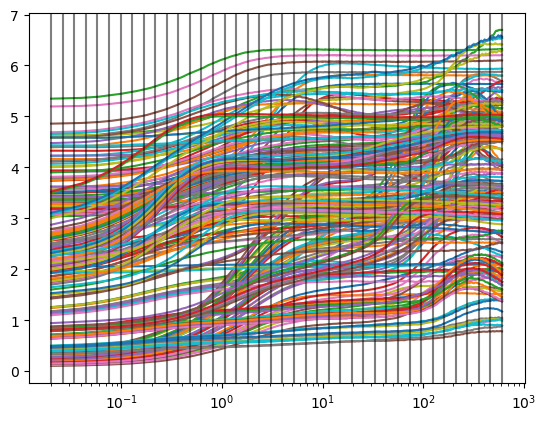

In [10]:
# Select the number of sampled points
n_points = 40

# Time points, logspaced
log_time_points = np.linspace(
    np.log10(dat.index[0]),
    np.log10(dat.index[-1]),
    n_points
)
time_points = 10 ** log_time_points

# Pre-populate the interp function
_interp = partial(np.interp, time_points, dat.index)

# Interpolate the selected points
ojip_sampled = dat.apply(_interp)
ojip_sampled.index = pd.MultiIndex.from_product([
    ["ojip"],
    ["ojip_" + x for x in log_time_points.round(2).astype(str)]
])

# Add sampled points to features
ojip_sampled = ojip_sampled.T

# Subset the data to the samples and time to be included in the analysis 
ax = dat.plot(legend=False)

for t in time_points:
    ax.axvline(t, c="k", alpha=0.5)

ax.set_xscale("log")

# Add data types
ojip_types = pd.Series({"ojip":"time-series-gradients"})

## Collect and split dataset

In [11]:
# Collect all data sets
dat_sets = [
    conditions,
    ojip_sampled,
    targets
]
dat_full = pd.concat(dat_sets, axis=1)

# Split data into training set
dat_train, _dat_trainval = train_test_split(
    dat_full,
    test_size=0.2, 
    random_state=SEED,
    stratify=dat_full[target_names]
)

# Split data into test and validation set
dat_test, dat_val = train_test_split(
    _dat_trainval,
    test_size=0.5, 
    random_state=SEED,
    stratify=_dat_trainval[target_names]
)

print(f"Dimensions train: {dat_train.shape}, test: {dat_test.shape}, val: {dat_val.shape}")


if not np.all(dat_train[target_names].drop_duplicates().sum(axis=0) == 1):
    raise RuntimeError("Not all targets are in the training set")

# Make into dataset
train_ds = fnc.df_to_dataset(dat_train, targets=target_names, batch_size=64, shuffle=True)
test_ds = fnc.df_to_dataset(dat_test, targets=target_names, shuffle=False)
val_ds = fnc.df_to_dataset(dat_val, targets=target_names, shuffle=False)

Dimensions train: (192, 56), test: (24, 56), val: (24, 56)


W0000 00:00:1749145951.694240 3407340 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [12]:
# Create function that shuffles the targets in a DataFrame
def shuffle_targets(df: pd.DataFrame, targets=["control_measurement", "PSII_closed", "CBB_inhibited", "TOX_inhibited", "electron_drain"]) -> pd.DataFrame:
    _df = df.copy()
    _df.loc[:,targets] = _df.loc[:,targets].sample(frac=1).values
    return _df

# Make shuffled datasets for baseline models
train_ds_sfl = fnc.df_to_dataset(shuffle_targets(dat_train), targets=target_names, batch_size=64, shuffle=True)
test_ds_sfl = fnc.df_to_dataset(shuffle_targets(dat_test), targets=target_names, shuffle=False)
val_ds_sfl = fnc.df_to_dataset(shuffle_targets(dat_val), targets=target_names, shuffle=False)

## Prepare data

In [13]:
from importlib import reload


fnc=reload(fnc)

2025-06-05 19:52:31.831138: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-06-05 19:52:31.860477: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-06-05 19:52:31.936485: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-06-05 19:52:32.036735: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


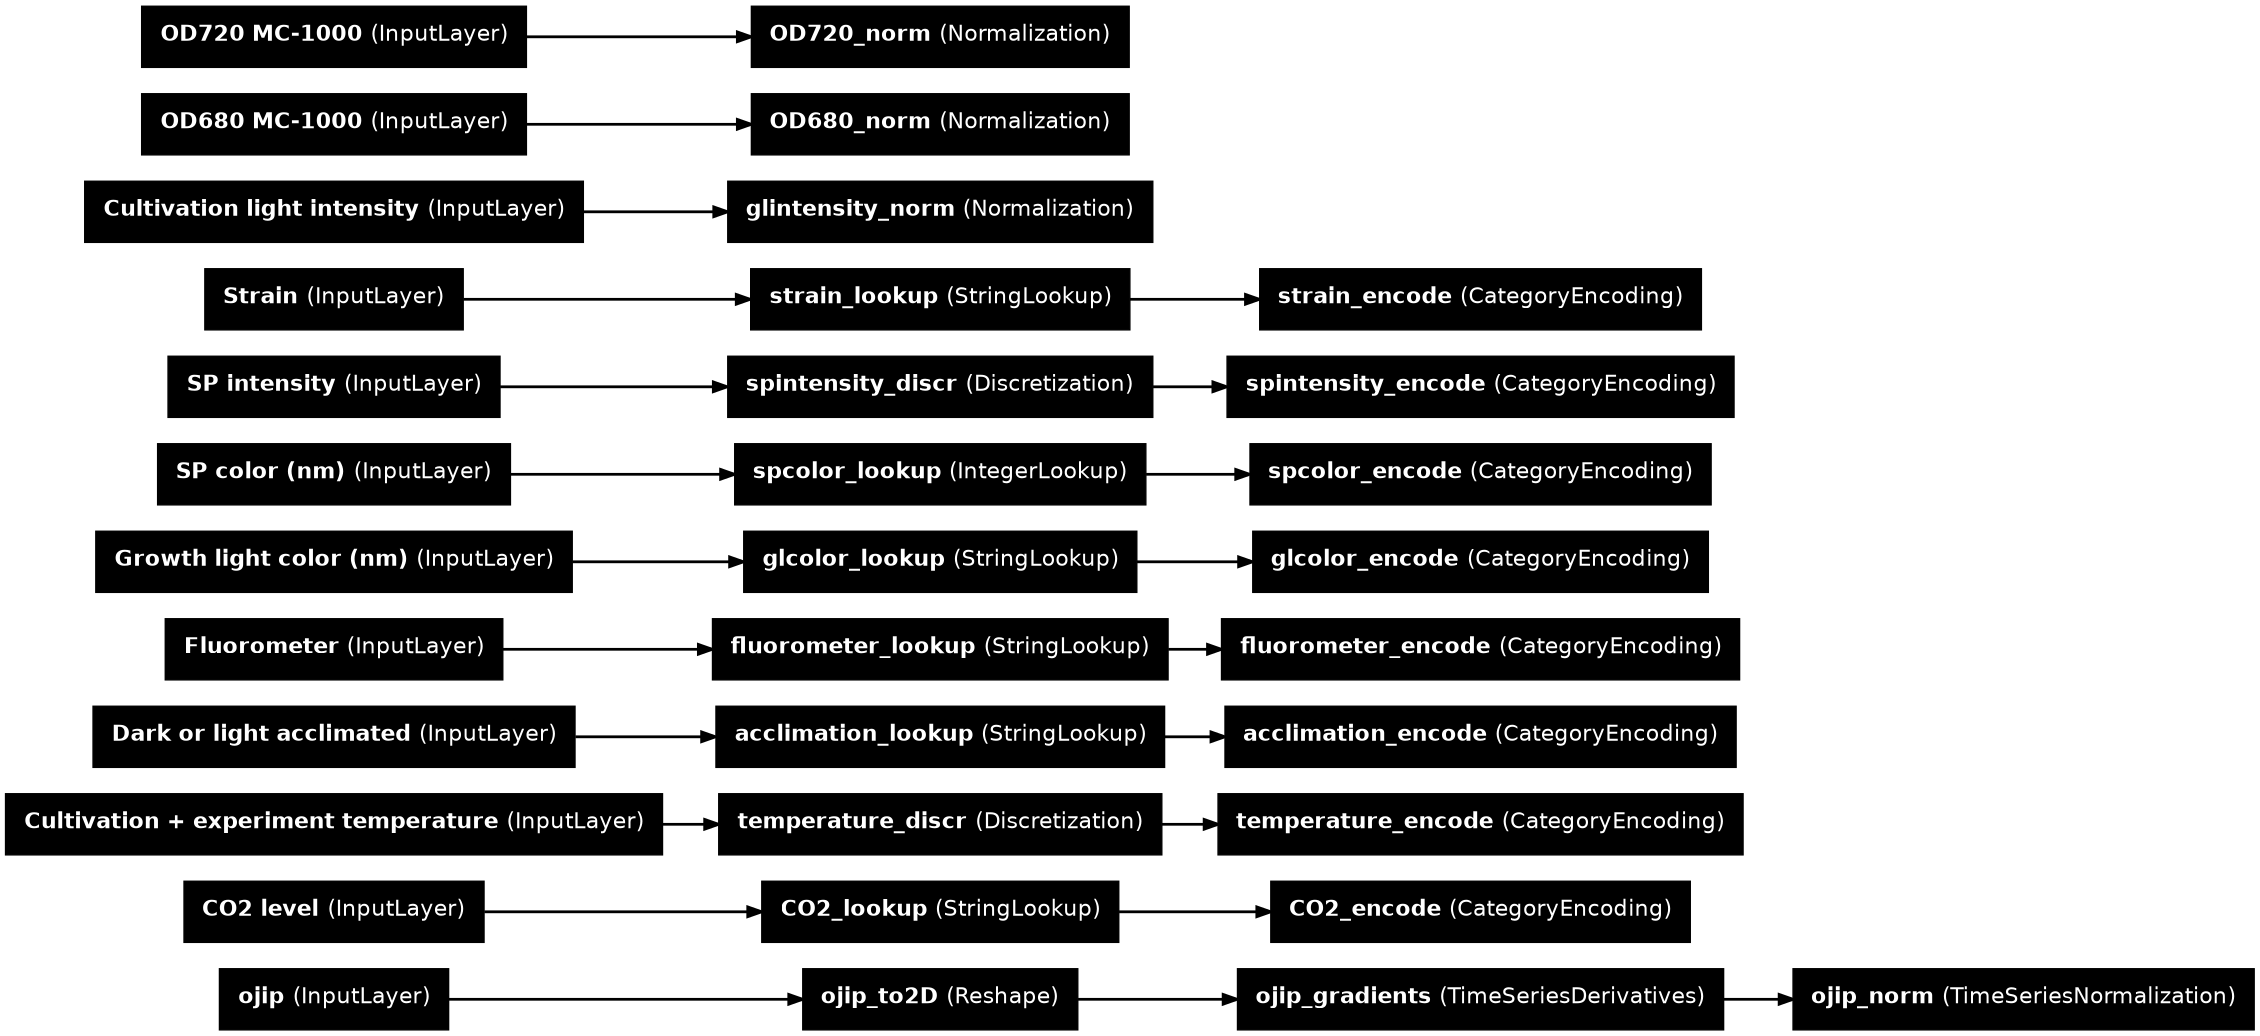

In [14]:
# Get the types of all features
feature_types = pd.concat([
    condition_types,
    ojip_types
])

# Create containers for inputs and encodings
all_inputs = {}
encoded_features_dict = {}
encoded_features = []

# Encode all features
for col_name, col_dtype in feature_types.items():

    if isinstance(col_dtype, str):
        # Create a numeric normalisation layer
        if col_dtype == "numeric":
            col = layers.Input(shape=(1,), name=col_name)
            normalization_layer = fnc.get_normalization_layer(col_name, train_ds, normLayer_name=f"{condition_labels[col_name]}_norm")
            encoded_col = normalization_layer(col)
        
        # Create a string enconding layer, could also work for integer encoding
        elif col_dtype in ["string", "int64"]:
            col = layers.Input(shape=(1,), name=col_name, dtype=col_dtype)
            encoding_layer = fnc.get_category_encoding_layer(name=col_name,
                                                        dataset=train_ds,
                                                        dtype=col_dtype,
                                                        max_tokens=5,
                                                        lookupLayer_name=f"{condition_labels[col_name]}_lookup",
                                                        encodingLayer_name=f"{condition_labels[col_name]}_encode",
                                                        )
            encoded_col = encoding_layer(col)

        # Create a layer to normalise time series and calculate gradients
        elif col_dtype == "time-series-gradients":
            col = layers.Input(shape=(dat_full[col_name].shape[1],), name=col_name)
            reshaped_col = layers.Reshape((dat_full[col_name].shape[1], 1), name=f"{condition_labels[col_name]}_to2D")(col)
            # normalization_layer = fnc.NormalizedTimeSeriesWithDerivatives()
            # encoded_col = normalization_layer(reshaped_col)

            gradient_layer = fnc.TimeSeriesDerivatives(name=f"{condition_labels[col_name]}_gradients")
            gradient_col = gradient_layer(reshaped_col)

            normalization_layer = fnc.TimeSeriesNormalization(name=f"{condition_labels[col_name]}_norm")
            encoded_col = normalization_layer(gradient_col)

        else:
            raise KeyError(f"No handling for col_dtype {col_dtype} defined")

    elif isinstance(col_dtype, tuple):
        # Create a discretized encoding for values with non-linear behaviour
        if col_dtype[0] == "bucket":
            col = layers.Input(shape=(1,), name=col_name, dtype="float32")
            encoding_layer = fnc.get_bucket_encoding_layer(name=col_name,
                                                        bin_boundaries=col_dtype[1],
                                                        dicretizationLayer_name=f"{condition_labels[col_name]}_discr", 
                                                        encodingLayer_name=f"{condition_labels[col_name]}_encode"
                                                        )
            encoded_col = encoding_layer(col)
        else:
            raise KeyError(f"No handling for col_dtype {col_dtype[0]} defined")
    else:
        raise KeyError(f"No handling for col_dtype {col_dtype} defined")

    all_inputs[col_name] = col
    encoded_features.append(encoded_col)
    encoded_features_dict[col_name] = encoded_col

# Define the preprocessing layer as a model
preprocessing_layer = keras.Model(
    all_inputs,
    encoded_features_dict,
    name="preprocessing_layer"
)

# Plot the preprocessing layer
keras.utils.plot_model(
    preprocessing_layer,
    # show_shapes=True,
    show_layer_names=True,
    rankdir="LR",
    to_file="figures/preprocessing.png",
    dpi=100
)

## Show the condition combinations

In [15]:
# def _discretize_ranges(_range , _index, _all_index, conditions):
#     if _range[0] is None:
#         conditions[_index] = conditions[_all_index] < _range[1]
#     elif _range[1] is None:
#         conditions[_index] = conditions[_all_index] > _range[0]
#     else:
#         conditions[_index] = np.logical_and(
#             conditions[_all_index] >= _range[0],
#             conditions[_all_index] < _range[1],
#         )
#     return conditions

def _discretize_ranges(_range , value, _all_index, conditions):
    if _range[0] is None:
        _range_bool = conditions[_all_index] < _range[1]
    elif _range[1] is None:
        _range_bool = conditions[_all_index] >= _range[0]
    else:
        _range_bool = np.logical_and(
            conditions[_all_index] >= _range[0],
            conditions[_all_index] < _range[1],
        )
    conditions.loc[_range_bool, (f"_{_all_index[0]}", _all_index[1])] = value
    return conditions


def discretize_ranges(conditions, condition_name, ranges):
    # Encode temperature in ranges as one-hot
    _all_index = (condition_name, condition_name)
    conditions[(f"_{condition_name}", condition_name)] = conditions[_all_index].astype(str)
    for nam, _range in ranges.items():
        conditions = _discretize_ranges(_range , nam, _all_index, conditions)

    conditions[_all_index] = conditions[(f"_{condition_name}", condition_name)]
    conditions=conditions.drop((f"_{condition_name}", condition_name), axis=1)
    return conditions

In [16]:
# Get the unique levels for selected conditions
conditions_table = conditions[[
    "Strain",
    "CO2 level",
    "Cultivation + experiment temperature",
    "Cultivation light intensity",
    "Dark or light acclimated",
    # "Fluorometer",
    # "Growth light color (nm)",
    "SP color (nm)",
    "SP intensity",
]].copy()

# Add the type of treatment
conditions_table["Treatment type"] = [effects_map[target_names].columns.get_level_values(1).to_numpy()[x][0] for x in targets.astype(bool).to_numpy()]

# Get all unique entries per columns type
unique_conditions = conditions_table.apply(np.unique)

for col_name, col_dtype in condition_types.items():
    if isinstance(col_dtype,tuple) and col_dtype[0]=="bucket":
        _ranges = [None] + col_dtype[1] + [None]
        ranges = {f"{_ranges[i]} - {_ranges[i+1]}":_ranges[i:i+2] for i in range(len(_ranges)-1)}
        conditions_table = discretize_ranges(conditions_table, col_name, ranges)

        # Add all buckets to the unique values
        unique_conditions[(col_name, col_name)] = list(ranges.keys())


In [17]:

# # Add the type of treatment
# conditions_table["Treatment type"] = [effects_map[target_names].columns.get_level_values(1).to_numpy()[x][0] for x in targets.astype(bool).to_numpy()]

# # Get all unique entries per columns type
# unique_conditions = conditions_table.apply(np.unique)

# Create all possible conditions combinations
all_condition_counts = pd.Series(
    data=0, 
    index=pd.MultiIndex.from_tuples(
        list(itertools.product(*unique_conditions.to_numpy())),
        names=conditions_table.columns.get_level_values(0)
    )
)

# Create all possible conditions combinations
all_condition_counts = pd.Series(
    data=0, 
    index=pd.MultiIndex.from_tuples(
        list(itertools.product(*unique_conditions.to_numpy())),
        names=conditions_table.columns.get_level_values(0)
    )
)

# Count the observations of each condition combination and place the min the total table
condition_counts = pd.Series(dict(Counter([tuple(x) for x in conditions_table.to_numpy()])))

all_condition_counts.update(condition_counts)

all_condition_counts = pd.concat([
    all_condition_counts.loc[all_condition_counts>0].sort_values(ascending=False),
    all_condition_counts.loc[all_condition_counts==0].sort_index()
])

all_condition_counts.name = "Sample counts"

all_condition_counts.to_csv("out/ojip_sample_counts.csv")
print(f"number of cases not covered: {(all_condition_counts==0).sum()}")

number of cases not covered: 19145


## Create UMAP mapping

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/home/tobias/miniforge3/envs/ojipml/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/tobias/miniforge3/envs/ojipml/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


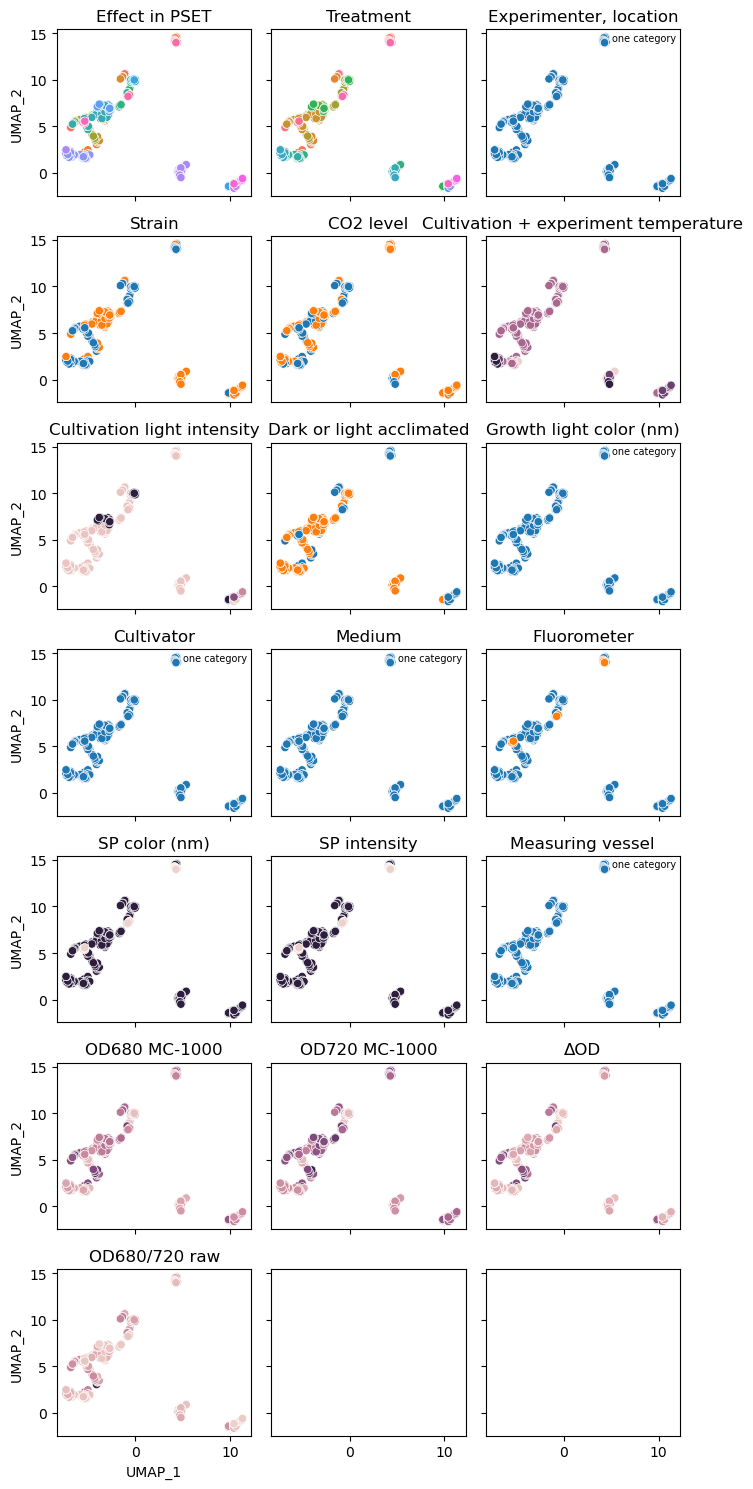

In [18]:
# Concatenate the outputs of the preprocessing layer to perform UMAP
preprocessed = preprocessing_layer(all_inputs)

# Append the derivatives of the ojip signal to the end to create a long feature vector
preprocessed["ojip"] = layers.Flatten()(preprocessed["ojip"])

concatenated_preprocess = keras.Model(
    all_inputs,
    layers.concatenate(list(preprocessed.values())),
    name="concatenation_layer"
)

# Scale the features
df_features_scaled = concatenated_preprocess.predict(
    fnc.get_dataset_from_input_df(dat_full, all_inputs)
)

# Create the UMAP embedding
reducer = umap.UMAP(random_state=SEED)
embedding = pd.DataFrame(
    reducer.fit_transform(df_features_scaled),
    index=dat_full.index,
    columns=["UMAP_1", "UMAP_2"]
).reset_index()

# Plot
categories = df.columns.names[1:]
fig, axes = plt.subplots(
    int(np.ceil(len(categories)/3)),
    3,
    figsize=(7,15),
    sharey=True,
    sharex=True,
)

for category, ax in zip(categories, axes.flatten()):
    sns.scatterplot(
        embedding,
        x="UMAP_1",
        y="UMAP_2",
        hue=category,
        ax=ax,
        legend=False
    )
    ax.set_title(category)

    if len(embedding[category].value_counts()) == 1:
        ax.text(s="one category",x=0.98, y=0.98, ha="right", va="top", transform=ax.transAxes, size=7)

fig.tight_layout()
fig.savefig("figures/umap_conditions.png")

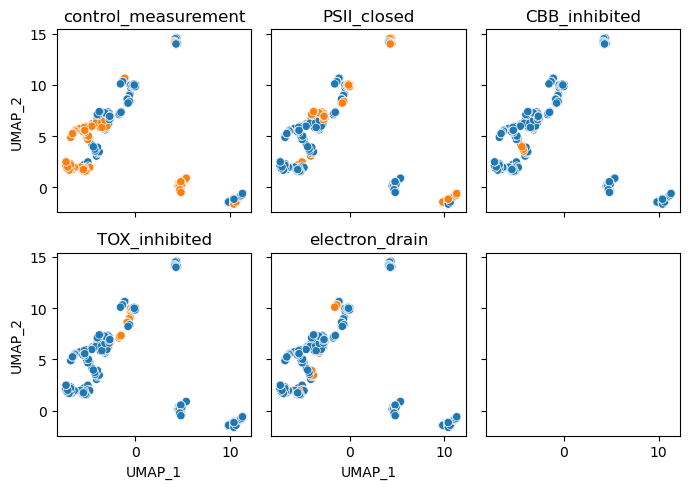

In [19]:
# Plot targest on UMAP
# Add UMAP to targets
embedding_targets = pd.concat([
    targets.droplevel(-1, axis=1).droplevel(list(range(1,20)), axis=0),
    embedding.set_index("Label").loc[:, ["UMAP_1", "UMAP_2"]],
], axis=1)

# Plot
categories = effects_map.columns.get_level_values(0)
fig, axes = plt.subplots(
    int(np.ceil(len(categories)/3)),
    3,
    figsize=(7,5),
    sharex=True,
    sharey=True
)

for category, ax in zip(categories, axes.flatten()):
    sns.scatterplot(
        embedding_targets,
        x="UMAP_1",
        y="UMAP_2",
        hue=category,
        ax=ax,
        legend=False
    )
    ax.set_title(category)

    if len(embedding_targets[category].value_counts()) == 1:
        ax.text(s="one category",x=0.98, y=0.98, ha="right", va="top", transform=ax.transAxes, size=7)

fig.tight_layout()
fig.savefig("figures/umap_treatments.png")

In [20]:
### UMAP with only OJIP information

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/home/tobias/miniforge3/envs/ojipml/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/tobias/miniforge3/envs/ojipml/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


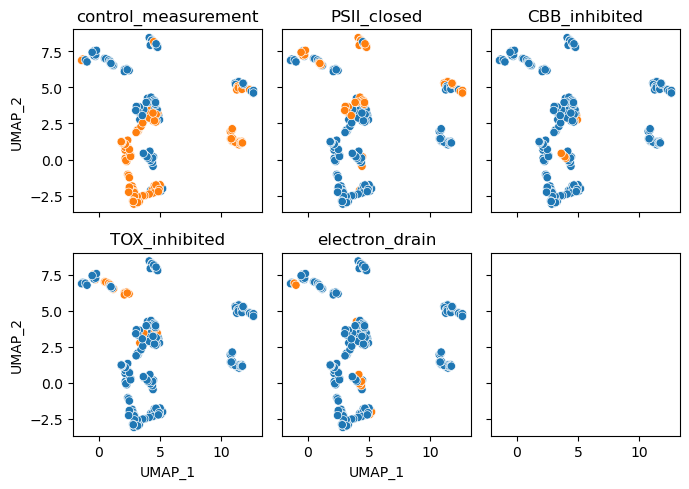

In [21]:
ojip_preprocess = keras.Model(
    all_inputs,
    preprocessed["ojip"],
    name="ojip_output"
)

# Scale the features
df_features_scaled = ojip_preprocess.predict(
    fnc.get_dataset_from_input_df(dat_full, all_inputs)
)

# Create the UMAP embedding
reducer = umap.UMAP(random_state=SEED)
embedding = pd.DataFrame(
    reducer.fit_transform(df_features_scaled),
    index=dat_full.index,
    columns=["UMAP_1", "UMAP_2"]
).reset_index()


# Add UMAP to targets
embedding_targets = pd.concat([
    targets.droplevel(-1, axis=1).droplevel(list(range(1,20)), axis=0),
    embedding.set_index("Label").loc[:, ["UMAP_1", "UMAP_2"]],
], axis=1)

# Plot
categories = effects_map.columns.get_level_values(0)
fig, axes = plt.subplots(
    int(np.ceil(len(categories)/3)),
    3,
    figsize=(7,5),
    sharex=True,
    sharey=True
)

for category, ax in zip(categories, axes.flatten()):
    sns.scatterplot(
        embedding_targets,
        x="UMAP_1",
        y="UMAP_2",
        hue=category,
        ax=ax,
        legend=False
    )
    ax.set_title(category)

    if len(embedding_targets[category].value_counts()) == 1:
        ax.text(s="one category",x=0.98, y=0.98, ha="right", va="top", transform=ax.transAxes, size=7)

fig.tight_layout()
fig.savefig("figures/umap_treatments_ojip.png")

## Model functions

In [22]:
def split_output_to_dict(dense_output):
    outputs = {
        "control_measurement": layers.Lambda(lambda x: tf.expand_dims(x[:, 0], axis=-1), name="control_measurement")(dense_output),
        "PSII_closed": layers.Lambda(lambda x: tf.expand_dims(x[:, 1], axis=-1), name="PSII_closed")(dense_output),
        "CBB_inhibited": layers.Lambda(lambda x: tf.expand_dims(x[:, 2], axis=-1), name="CBB_inhibited")(dense_output),
        "TOX_inhibited": layers.Lambda(lambda x: tf.expand_dims(x[:, 3], axis=-1), name="TOX_inhibited")(dense_output),
        "electron_drain": layers.Lambda(lambda x: tf.expand_dims(x[:, 4], axis=-1), name="electron_drain")(dense_output),
    }
    return outputs

## Create test model

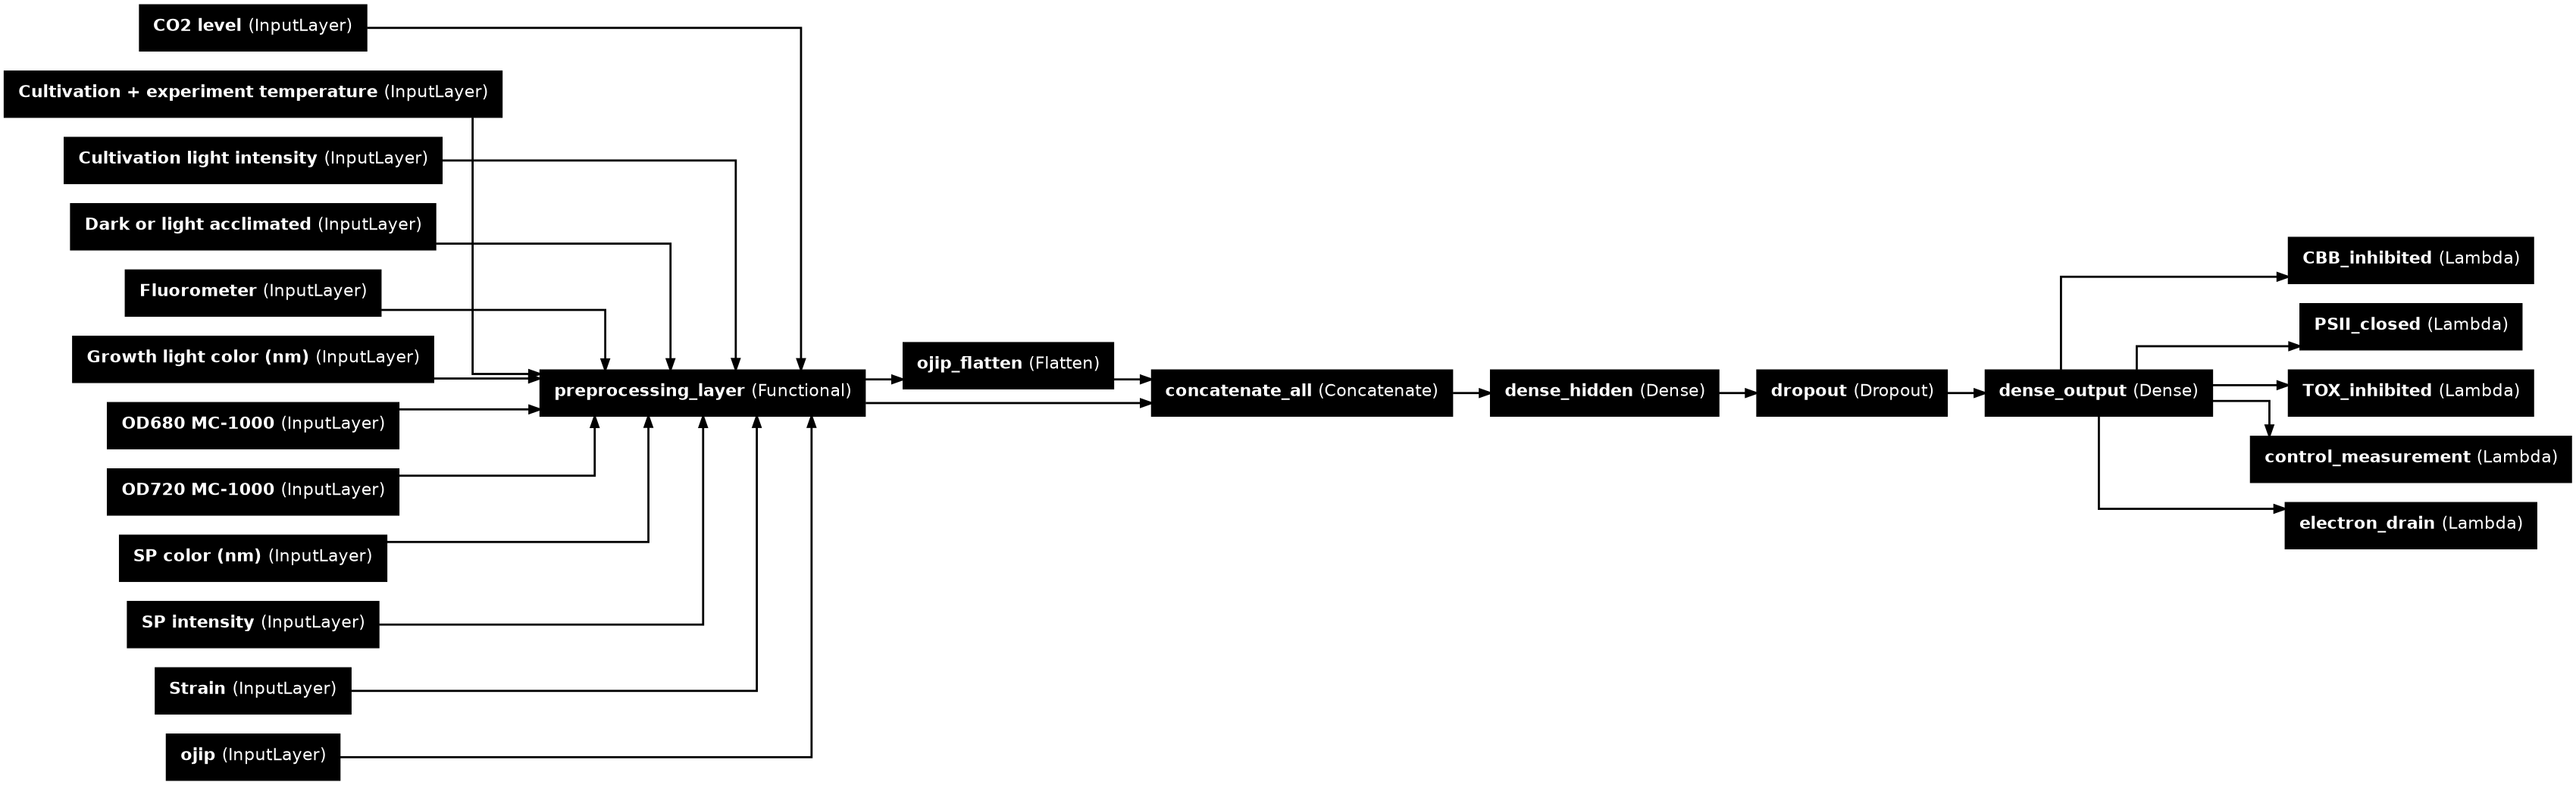

In [23]:
## Test model
# Get the preprocessed inputs
def get_dense_model(all_inputs):
    preprocessed = preprocessing_layer(all_inputs)

    # Append the derivatives of the ojip signal to the end to create a long feature vector
    preprocessed["ojip"] = layers.Flatten(name="ojip_flatten")(preprocessed["ojip"])

    # Concatenate all features
    x = layers.concatenate(list(preprocessed.values()), name="concatenate_all")

    # Dense hidden layer
    x = layers.Dense(32, activation="relu", name="dense_hidden")(x)
    x = layers.Dropout(0.5, name="dropout")(x)

    # Dense layer for output calculation
    # Uses sigmoid activation function for output between 0 and 1
    dense_output = layers.Dense(targets.shape[1], activation="sigmoid", name="dense_output")(x)

    # Split the output into a dictionary
    outputs = split_output_to_dict(dense_output)


    # Create and compile test model
    dense_model = keras.Model(all_inputs, outputs)
    dense_model.compile(
        loss='binary_crossentropy', # Expects output to be multiple probabilities for classes
        optimizer='adam',
        metrics={key:[ # Calculate metrics for each target
            keras.metrics.BinaryAccuracy(threshold=0.5, name="..binary_accuracy"), # Accuracy (assumes threshold 0.5)
            keras.metrics.Recall(thresholds=0.5, name="..recall"), # Recall (assumes threshold 0.5)
            keras.metrics.Precision(thresholds=0.5, name="..precision"), # Precision (assumes threshold 0.5)
            keras.metrics.F1Score(threshold=0.5, name="..f1_score"), # F1-score (assumes threshold 0.5)
            ] for key in target_names},
    )
    return dense_model

dense_model = get_dense_model(all_inputs)

# Plot the model
keras.utils.plot_model(
    dense_model,
    # show_shapes=True,
    show_layer_names=True,
    to_file="figures/dense_model.png",
    rankdir="LR",
    # rankdir="TB",
    # expand_nested=True,
    dpi=100
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

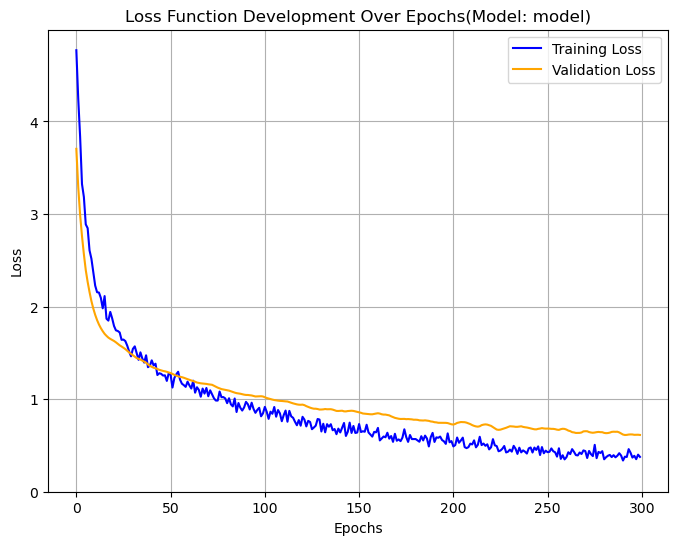

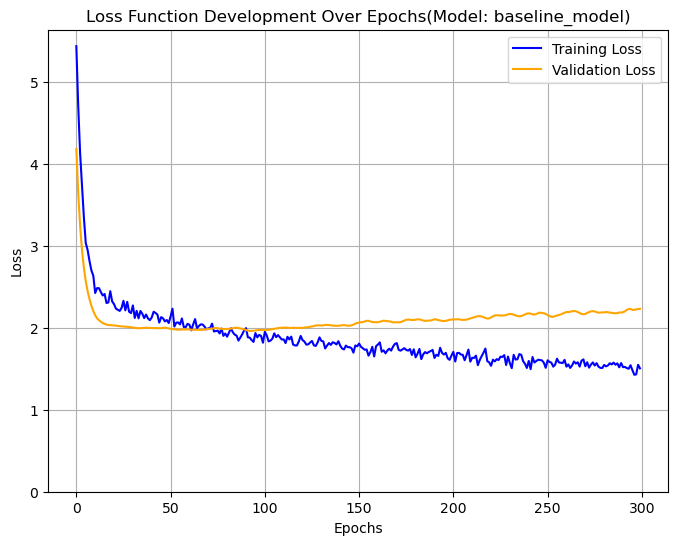

In [27]:
# Train the model

dense_models = {
    "model": get_dense_model(all_inputs),
    "baseline_model": get_dense_model(all_inputs),
}

for name, model in dense_models.items():
    if name == "model":
        data = train_ds
    elif name == "baseline_model":
        data = train_ds_sfl

    # Use tensorboard to track the training
    use_tensorboard = False
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = [keras.callbacks.TensorBoard(log_dir=log_dir)] if use_tensorboard else []

    dense_model_history = model.fit(
        data,
        epochs=300,
        batch_size=32,
        verbose=0,
        validation_data=val_ds,
        callbacks=[
            TqdmCallback(verbose=1)
        ] + tensorboard_callback
    )

    # Plot the loss over the Epochs
    fig, ax = fnc.plot_loss_development(dense_model_history, f"(Model: {name})")
    fig.savefig("figures/dense_loss.png")

### Evaluate on the test data

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - CBB_inhibited_..binary_accuracy: 0.9167 - CBB_inhibited_..f1_score: 0.0000e+00 - CBB_inhibited_..precision: 0.0000e+00 - CBB_inhibited_..recall: 0.0000e+00 - CBB_inhibited_loss: 0.3180 - PSII_closed_..binary_accuracy: 0.7500 - PSII_closed_..f1_score: 0.0000e+00 - PSII_closed_..precision: 0.0000e+00 - PSII_closed_..recall: 0.0000e+00 - PSII_closed_loss: 0.7657 - TOX_inhibited_..binary_accuracy: 0.9167 - TOX_inhibited_..f1_score: 0.0000e+00 - TOX_inhibited_..precision: 0.0000e+00 - TOX_inhibited_..recall: 0.0000e+00 - TOX_inhibited_loss: 0.3771 - control_measurement_..binary_accuracy: 0.5000 - control_measurement_..f1_score: 0.6000 - control_measurement_..precision: 0.5294 - control_measurement_..recall: 0.6923 - control_measurement_loss: 0.7495 - electron_drain_..binary_accuracy: 0.9583 - electron_drain_..f1_score: 0.0000e+00 - electron_drain_..precision: 0.0000e+00 - electron_drain_..recall: 0.0000e+00 - electron_drain_loss: 0.1502 - loss: 2.3605

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - CBB_inhibited_..binary_accuracy: 0.9167 - CBB_inhibited_..f1_score: 0.0000e+00 - CBB_inhibited_..precision: 0.0000e+00 - CBB_inhibited_..recall: 0.0000e+00 - CBB_inhibited_loss: 0.3180 - PSII_closed_..binary_accuracy: 0.7500 - PSII_closed_..f1_score: 0.0000e+00 - PSII_closed_..precision: 0.0000e+00 - PSII_closed_..recall: 0.0000e+00 - PSII_closed_loss: 0.7657 - TOX_inhibited_..binary_accuracy: 0.9167 - TOX_inhibited_..f1_score: 0.0000e+00 - TOX_inhibited_..precision: 0.0000e+00 - TOX_inhibited_..recall: 0.0000e+00 - TOX_inhibited_loss: 0.3771 - control_measurement_..binary_accuracy: 0.5000 - control_measurement_..f1_score: 0.6000 - control_measurement_..precision: 0.5294 - control_measurement_..recall: 0.6923 - control_measurement_loss: 0.7495 - electron_drain_..binary_accuracy: 0.9583 - electron_drain_..f1_score: 0.0000e+00 - electron_drain_..precision: 0.0000e+00 - electron_drain_..recall: 0.0000e+00 - electron_drain_loss: 0.1502 - loss: 2.3605

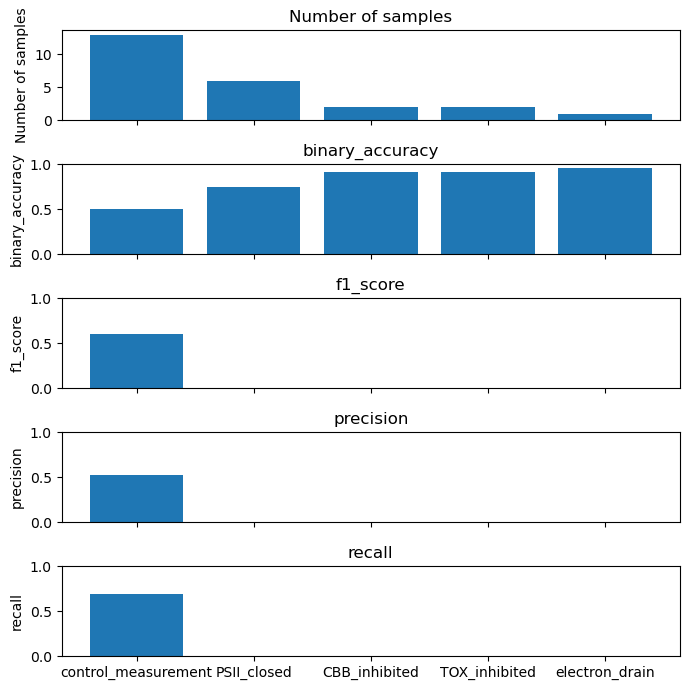

In [29]:
# Evaluate the model on the test data
dense_model = dense_models["baseline_model"]
dense_model_eval = dense_model.evaluate(test_ds, return_dict=True)

fig, axes = fnc.plot_model_metrics(dense_model_eval, test_ds)
fig.savefig("figures/dense_metrics.png")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - CBB_inhibited_..binary_accuracy: 0.9844 - CBB_inhibited_..f1_score: 0.8516 - CBB_inhibited_..precision: 1.0000 - CBB_inhibited_..recall: 0.7422 - CBB_inhibited_loss: 0.0422 - PSII_closed_..binary_accuracy: 0.9974 - PSII_closed_..f1_score: 0.9944 - PSII_closed_..precision: 1.0000 - PSII_closed_..recall: 0.9889 - PSII_closed_loss: 0.0501 - TOX_inhibited_..binary_accuracy: 1.0000 - TOX_inhibited_..f1_score: 1.0000 - TOX_inhibited_..precision: 1.0000 - TOX_inhibited_..recall: 1.0000 - TOX_inhibited_loss: 0.0181 - control_measurement_..binary_accuracy: 0.9857 - control_measurement_..f1_score: 0.9870 - control_measurement_..precision: 0.9870 - control_measurement_..recall: 0.9870 - control_measurement_loss: 0.0844 - electron_drain_..binary_accuracy: 1.0000 - electron_drain_..f1_score: 1.0000 - electron_drain_..precision: 1.0000 - electron_drain_..recall: 1.0000 - electron_drain_loss: 0.0134 - loss: 0.2083


Text(0.5, 1, 'Increase in metric for training data')

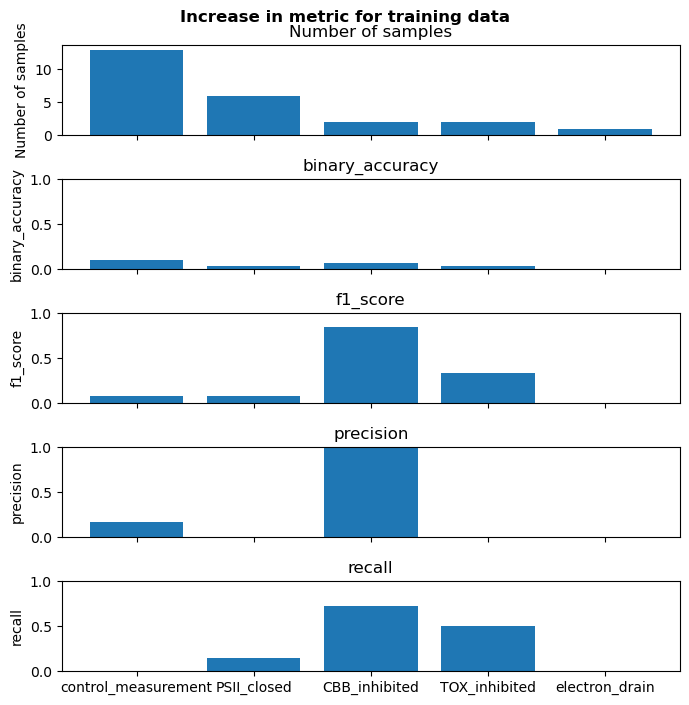

In [34]:
# Calculate the metrics for the training data to compare with test data and evaluate overfitting
dense_model_eval_train = dense_model.evaluate(train_ds, return_dict=True)

dense_model_eval_compare = {x:(dense_model_eval_train[x] - dense_model_eval[x]) for x in dense_model_eval}

fig, axes = fnc.plot_model_metrics(dense_model_eval_compare, test_ds)
fig.suptitle("Increase in metric for training data", y=1, weight="bold")

## Test with only ojip data

In [ ]:
## Dense model with only OJIP

# Get the preprocessed inputs
preprocessed = preprocessing_layer(all_inputs)

# Append the derivatives of the ojip signal to the end to create a long feature vector
preprocessed["ojip"] = layers.Flatten()(preprocessed["ojip"])

# Dense hidden layer
x = layers.Dense(32, activation="relu")(preprocessed["ojip"])
x = layers.Dropout(0.5)(x)

# Dense layer for output calculation
# Uses sigmoid activation function for output between 0 and 1
dense_output = layers.Dense(targets.shape[1], activation="sigmoid")(x)

# Split the output into a dictionary
outputs = split_output_to_dict(dense_output)


# Create and compile test model
dense_model_ojip = keras.Model(all_inputs, outputs)
dense_model_ojip.compile(
    loss='binary_crossentropy', # Expects output to be multiple probabilities for classes
    optimizer='adam',
    metrics={key:[ # Calculate metrics for each target
        keras.metrics.BinaryAccuracy(threshold=0.5, name="..binary_accuracy"), # Accuracy (assumes threshold 0.5)
        keras.metrics.Recall(thresholds=0.5, name="..recall"), # Recall (assumes threshold 0.5)
        keras.metrics.Precision(thresholds=0.5, name="..precision"), # Precision (assumes threshold 0.5)
        keras.metrics.F1Score(threshold=0.5, name="..f1_score"), # F1-score (assumes threshold 0.5)
        ] for key in target_names},
)

# Train the model

# Use tensorboard to track the training
use_tensorboard = False
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = [keras.callbacks.TensorBoard(log_dir=log_dir)] if use_tensorboard else []

dense_model_ojip_history = dense_model_ojip.fit(
    train_ds,
    epochs=300,
    batch_size=32,
    verbose=0,
    validation_data=val_ds,
    callbacks=[
        TqdmCallback(verbose=1)
    ] + tensorboard_callback
)

# Plot the loss over the Epochs
fig, ax = fnc.plot_loss_development(dense_model_ojip_history)
fig.savefig("figures/dense_loss_ojip.png")

In [ ]:
# Evaluate the model on the test data
dense_model_ojip_eval = dense_model_ojip.evaluate(test_ds, return_dict=True)

fig, axes = fnc.plot_model_metrics(dense_model_ojip_eval, test_ds)
fig.savefig("figures/dense_metrics.png")

# Create LSTM model

In [ ]:
## Define the model
# Get the preprocessed inputs
seperated_inputs = preprocessing_layer(all_inputs)

# Add an LSTM layer to the OJIP input
seperated_inputs["ojip"] = layers.LSTM(16, activation="tanh", name="LSTM_ojip")(seperated_inputs["ojip"])
seperated_inputs["ojip"] = layers.Dropout(0.5, name="LSTM_1_Dropout")(seperated_inputs["ojip"])

# Concatenate all features
x = layers.concatenate(list(seperated_inputs.values()))

# Dense hidden layer
x = layers.Dense(16, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# Dense layer for output calculation
# Uses sigmoid activation function for output between 0 and 1
dense_output = layers.Dense(targets.shape[1], activation="sigmoid")(x)

# Split the output into a dictionary
outputs = split_output_to_dict(dense_output)

# Create and compile test model
model = keras.Model(all_inputs, outputs)
model.compile(
    loss='binary_crossentropy', # Expects output to be multiple probabilities for classes
    optimizer='adam',
    metrics={key:[ # Calculate metrics for each target
        keras.metrics.BinaryAccuracy(threshold=0.5, name="..binary_accuracy"), # Accuracy (assumes threshold 0.5)
        keras.metrics.Recall(thresholds=0.5, name="..recall"), # Recall (assumes threshold 0.5)
        keras.metrics.Precision(thresholds=0.5, name="..precision"), # Precision (assumes threshold 0.5)
        keras.metrics.F1Score(threshold=0.5, name="..f1_score"), # F1-score (assumes threshold 0.5)
        ] for key in target_names},
)

# Plot the model
keras.utils.plot_model(
    model,
    # show_shapes=True,
    show_layer_names=True,
    to_file="figures/lstm_model.png",
    rankdir="LR",
    dpi=100
)

In [ ]:
# Train the model

# Use tensorboard to track the training
use_tensorboard = False
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = [keras.callbacks.TensorBoard(log_dir=log_dir)] if use_tensorboard else []

model_history = model.fit(
    train_ds,
    epochs=800,
    verbose=0,
    validation_data=val_ds,
    callbacks=[
        TqdmCallback(verbose=1)
    ] + tensorboard_callback
)

# Plot the loss over the Epochs
fig, ax = fnc.plot_loss_development(model_history)
fig.savefig("figures/lstm_loss.png")

In [ ]:
# Plot the final metrics of a model
def plot_history_metrics(history, fit_dataset, val_dataset):
    # Get the targets from the dataset to count occurrences
    target_numbers={}
    for nam, ds in {"fit":fit_dataset, "val":val_dataset}.items():
        _targets_subsets = list(ds.map(lambda x,y: y).as_numpy_iterator())
        _targets = [pd.DataFrame({k:v.flatten() for k,v in _targets_subset.items()}) for _targets_subset in _targets_subsets]
        _targets = pd.concat(_targets, axis=0)

        target_numbers[nam] = _targets.sum().sort_values(ascending=False)

    metrics = history.history

    # Get all metrics and assign them to the targets
    plot_metrics = pd.DataFrame(
        {tuple(k.split("_..")): v for k,v in metrics.items() if not k.endswith("loss")}
    )

    print(plot_metrics.columns.levels[0])

    metrics_names = plot_metrics.columns.levels[1]
    targets_names = _targets.columns

    # Create the figure
    fig, axes = plt.subplots(
        len(targets_names), 
        2,
        figsize=(7,7),
        sharex=True,
        sharey=True
    )

    # Plot each target
    for j, val in enumerate(["fit", "val"]):
        for i, _target in enumerate(targets_names):
            prefix = "val_" if val=="val" else ""
            target = prefix + _target
            axes[i, j].plot(
                plot_metrics.loc[:, idx[target, metrics_names]],
                label=metrics_names
            )
            axes[i, j].set_title(f"{target} (n={target_numbers[val][_target]})")

        axes[-1, j].set_xlabel("Epoch No.")

    for ax in axes[:,0]:
        ax.set_ylabel("Metric")

    fig.tight_layout()

    axes[0, -1].legend(loc="upper left", bbox_to_anchor=(1,1))

    return fig, axes

In [ ]:
fig, axes = plot_history_metrics(history=model_history, fit_dataset=train_ds, val_dataset=val_ds)
for ax in axes.flatten():
    ax.set_ylim(0,1)
fig.savefig("figures/lstm_metrics_over_time.png")

In [ ]:
# Evaluate the model on the test data
model_eval = model.evaluate(test_ds, return_dict=True)

fig, axes = fnc.plot_model_metrics(model_eval, test_ds, ylim=(0, 1))
fig.savefig("figures/lstm_metrics.png")

## Test with only OJIP data

In [ ]:
## Define the model_ojip
# Get the preprocessed inputs
seperated_inputs = preprocessing_layer(all_inputs)

# Add an LSTM layer to the OJIP input
seperated_inputs["ojip"] = layers.LSTM(16, activation="tanh", name="LSTM_ojip")(seperated_inputs["ojip"])
seperated_inputs["ojip"] = layers.Dropout(0.5, name="LSTM_1_Dropout")(seperated_inputs["ojip"])

# Dense hidden layer
x = layers.Dense(16, activation="relu")(seperated_inputs["ojip"])
x = layers.Dropout(0.5)(x)

# Dense layer for output calculation
# Uses sigmoid activation function for output between 0 and 1
dense_output = layers.Dense(targets.shape[1], activation="sigmoid")(x)

# Split the output into a dictionary
outputs = split_output_to_dict(dense_output)

# Create and compile test model
model_ojip = keras.Model(all_inputs, outputs)
model_ojip.compile(
    loss='binary_crossentropy', # Expects output to be multiple probabilities for classes
    optimizer='adam',
    metrics={key:[ # Calculate metrics for each target
        keras.metrics.BinaryAccuracy(threshold=0.5, name="..binary_accuracy"), # Accuracy (assumes threshold 0.5)
        keras.metrics.Recall(thresholds=0.5, name="..recall"), # Recall (assumes threshold 0.5)
        keras.metrics.Precision(thresholds=0.5, name="..precision"), # Precision (assumes threshold 0.5)
        keras.metrics.F1Score(threshold=0.5, name="..f1_score"), # F1-score (assumes threshold 0.5)
        ] for key in target_names},
)

# Train the model

# Use tensorboard to track the training
use_tensorboard = False
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = [keras.callbacks.TensorBoard(log_dir=log_dir)] if use_tensorboard else []

model_ojip_history = model_ojip.fit(
    train_ds,
    epochs=800,
    verbose=0,
    validation_data=val_ds,
    callbacks=[
        TqdmCallback(verbose=1)
    ] + tensorboard_callback
)

# Plot the loss over the Epochs
fig, ax = fnc.plot_loss_development(model_ojip_history)
fig.savefig("figures/lstm_loss_ojip.png")


# Evaluate the model on the test data
model_ojip_eval = model_ojip.evaluate(test_ds, return_dict=True)

fig, axes = fnc.plot_model_metrics(model_ojip_eval, test_ds, ylim=(0, 1))
fig.savefig("figures/lstm_metrics_ojip.png")

# Look at all models

In [ ]:
# Plot the final metrics of a model
def plot_model_metrics_multi(metrics_dict:dict, dataset, ylim=(0,1), width_scale=0.5):
    for m, model in enumerate(metrics_dict):
        metrics = metrics_dict[model]
        # Get the targets from the dataset to count occurrences
        _targets_subsets = list(dataset.map(lambda x,y: y).as_numpy_iterator())
        _targets = [pd.DataFrame({k:v.flatten() for k,v in _targets_subset.items()}) for _targets_subset in _targets_subsets]
        _targets = pd.concat(_targets, axis=0)
        target_number = _targets.sum().sort_values(ascending=False)

        # Get all metrics and assign them to the targets
        plot_metrics = pd.Series(
            {tuple(k.split("_..")): v for k,v in metrics.items() if not k.endswith("loss")}
        )
        metrics_names = plot_metrics.index.levels[1]


        # Create the figure
        if m==0:
            fig, axes = plt.subplots(
                len(metrics_names) + 1, 
                1,
                figsize=(7,7),
                sharex=True
            )
            offset = 1/len(metrics_dict) * width_scale
            width = 1/(len(metrics_dict)) * width_scale

        # Plot the number of occurrences
        axes[0].bar(
            range(len(target_number)),
            target_number,
            label=model
        )
        axes[0].set_title("Number of samples")
        axes[0].set_ylabel("Number of samples")

        for i, metric in enumerate(metrics_names):
            axes[i+1].bar(
                np.arange(len(target_number)) - (0.25 * width_scale) + m * offset,
                plot_metrics.loc[idx[target_number.index, metric]],
                width=width,
                label=model
            )
            axes[i+1].set_title(metric)
            axes[i+1].set_ylabel(metric)
            axes[i+1].set_ylim(ylim)


        axes[-1].set_xticks(list(range(len(target_number))), target_number.index.to_numpy())
        fig.tight_layout()

        axes[0].legend()

    return fig, axes

In [ ]:
all_metrics = {
    "dense": dense_model_eval,
    "dense_ojip": dense_model_ojip_eval,
    "lstm": model_eval,
    "lstm_ojip": model_ojip_eval,

}

plot_model_metrics_multi(all_metrics, test_ds)
fig.savefig("figures/combined_metrics.png")

In [ ]:
# fig, axes = plt.subplots(len(models_metrics), sharex=True)

# for model, ax in zip(models_metrics, axes.flatten()):
#     # Plot the model metrics
#     models_metrics[model].plot(kind="bar", ax=ax)
#     ax.set_title(model)

In [ ]:

# model.compile(loss='mae', optimizer='adam')
# model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=0)

# print(model.evaluate(X_test, y_test))
# # 10.704551696777344

# # normalize the inputs outside the model
# normalizer = Normalization()
# normalizer.adapt(X_train)

# X_train_normalized = normalizer(X_train)
# X_test_normalized = normalizer(X_test)

# inputs = Input(shape=[None, 1])
# x = LSTM(4, return_sequences=True)(inputs)
# x = LSTM(2, return_sequences=True)(x)
# x = LSTM(2, return_sequences=True)(x)
# x = LSTM(4, return_sequences=True)(x)
# x = TimeDistributed((Dense(1)))(x)
# model = Model(inputs, x)

# model.compile(loss='mae', optimizer='adam')
# model.fit(X_train_normalized, y_train, batch_size=32, epochs=10, verbose=0)

# print(model.evaluate(X_test_normalized, y_test))
# # 10.748750686645508

In [ ]:
# import tensorflow as tf

# class TimeSeriesNormalization(layers.Layer):
#     def __init__(self, epsilon=1e-6):
#         super(TimeSeriesNormalization, self).__init__()
#         self.epsilon = epsilon  # To prevent division by zero

#     def call(self, inputs):
#         """
#         Normalize each time series independently to zero mean and unit variance.

#         Args:
#             inputs: Tensor of shape (batch_size, time_steps, features)

#         Returns:
#             Normalized tensor of the same shape
#         """
#         mean = tf.reduce_mean(inputs, axis=1, keepdims=True)  # Compute mean along time axis
#         std = tf.math.reduce_std(inputs, axis=1, keepdims=True)  # Compute std along time axis

#         return (inputs - mean) / (std + self.epsilon)  # Normalize

# # Example usage
# batch_size, time_steps, features = 32, 100, 5
# input_data = tf.random.normal((batch_size, time_steps, features))  # Simulated time series data

# normalization_layer = TimeSeriesNormalization()
# normalized_data = normalization_layer(input_data)

# print("Input shape:", input_data.shape)
# print("Normalized shape:", normalized_data.shape)


In [ ]:
# fig,ax = plt.subplots()
# ax.plot(normalized_data.numpy().std(axis=1))
# ax.set_ylim(-1,3)